In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline
import corner

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
text_size = 16

In [182]:
m_min = 3.
m_max = 15.
alpha = 1.35
N= 1000
#theta = (m_min, m_max, alpha)
const = 1/(integrate.quad(lambda x: x**(-alpha),m_min, m_max))[0]

## Part (a)

In [190]:
def get_masses(m_min, m_max, alpha, N):
    """Generates a list of masses from a power law with slope alpha. The function takes a list
    with elements (minimum mass, maximum mass, alpha) and N, the number of mass elements in 
    output."""
    masses = ((np.random.power(alpha+0.5, N)))*(m_min - m_max) + m_max
    return masses
masses = get_masses(m_min, m_max, alpha, N)

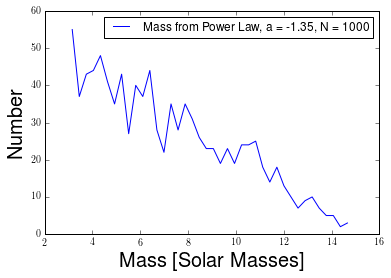

In [184]:
#make a histogram out of the output masses
hist, bin_edges = np.histogram(masses, bins = 40)
mass = (bin_edges[:-1]+bin_edges[1:])/2

plt.figure(1)
plt.plot(mass,hist, label = 'Mass from Power Law, a = -1.35, N = %s'%N)
plt.xlabel(r'Mass [Solar Masses]', fontsize = text_size)
plt.ylabel(r'Number', fontsize = text_size)
plt.legend()
plt.savefig('mass_histogram_prob2_%s_data.png'%N, dpi = 300)
plt.show()

## Part (b)

In [185]:
def ln_like(theta, mass, hist, m_min):
    """Likelihood function that operates in log space and aims to minimize the residual between
    the histogram of the mass data and the trial power-law fit using the least squares method."""
    alpha, m_max = theta
    mass = np.log(mass)
    hist = np.log(hist)
    if (integrate.quad(lambda x: x**(-alpha),m_min, m_max))[0] <= 0:
        return -np.inf
    c = 1/(integrate.quad(lambda x: x**(-alpha),m_min, m_max))[0]
    val = np.log(c)-alpha*mass
    return -np.sum((hist - val)**2)

def lnprior(theta, m_min):
    """Prior function that assumed top hat prior for alpha is a positive number between 0 and 5
    and m_max must be greater than m_min."""
    alpha, m_max = theta
    if 0.0 < alpha < 5.0 and m_max > m_min: 
        return 0.0 
    return -np.inf

def lnprob(theta, mass, hist, m_min):
    """Here I combine the prior and the likelihood function in log space to get the probability"""
    lp = lnprior(theta, m_min)
    if not np.isfinite(lp):
        return -np.inf
    return lp +  ln_like(theta, mass, hist,  m_min)  

n_walkers = 100
ndim = 2
n_steps = 1000
initial = np.array([np.random.rand(ndim) for i in range(n_walkers)])
initial[:,1] = initial[:,1]*(m_max-m_min)+m_min
sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[mass, hist, m_min])
sampler.run_mcmc(initial, n_steps)

(array([[ 1.7609072 ,  3.00803557],
        [ 1.09332936,  3.01887444],
        [ 1.61343593,  3.01034132],
        [ 1.32383396,  3.01267194],
        [ 1.35388235,  3.01502928],
        [ 1.20744509,  3.01564984],
        [ 1.61388851,  3.00875846],
        [ 1.3169548 ,  3.01321992],
        [ 1.74088116,  3.00835011],
        [ 0.97622234,  3.02276687],
        [ 1.48687869,  3.01394501],
        [ 1.54814915,  3.01066017],
        [ 1.79715004,  3.00905781],
        [ 1.84551868,  3.00644827],
        [ 1.2445164 ,  3.01973093],
        [ 1.49986173,  3.01160714],
        [ 1.43028062,  3.01076303],
        [ 1.3130048 ,  3.01676063],
        [ 1.43000589,  3.01044319],
        [ 1.28540168,  3.01548533],
        [ 1.15972804,  3.01725045],
        [ 1.20440689,  3.01411051],
        [ 1.24675676,  3.02153878],
        [ 1.23250124,  3.01419656],
        [ 1.68086751,  3.01077688],
        [ 1.2390675 ,  3.01797543],
        [ 1.69851767,  3.01109723],
        [ 1.24739489,  3.016

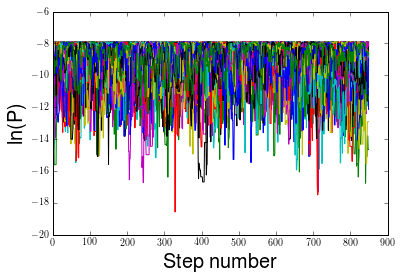

In [186]:
#Plot of ln(P) vs Step Number for finding alpha and const using emcee
plt.figure(3)
[plt.plot(sampler.lnprobability[i,150:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
#plt.savefig("lnp_step_emcee_prob2.png", dpi=300)

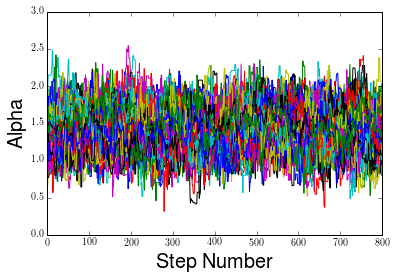

In [187]:
plt.figure(4)
[plt.plot(sampler.chain[i,200:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Alpha', fontsize = text_size)
#plt.savefig("alpha_step_emcee_prob2.png", dpi=300)

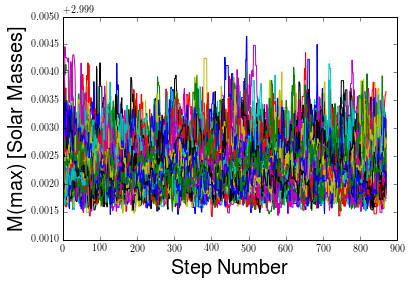

In [179]:
plt.figure(5)
[plt.plot(sampler.chain[i,130:,1]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'M(max) [Solar Masses]', fontsize = text_size)
#plt.savefig("m_max_step_emcee_prob2.png", dpi=300)

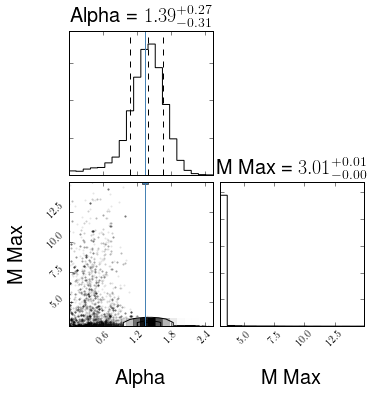

In [188]:
corner_plot = corner.corner(sampler.flatchain[100:,:], labels = ['Alpha','M Max'], show_titles = True,\
              plot_contours = True, truths = [1.35, 15], quantiles = [0.16,0.5,0.84],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20})
corner_plot.show()
#corner_plot.savefig("corner_plot_emcee_prob2_%s_data.png"%N, dpi=300)

While the alpha value is close to expected, I couldn't get the walkers to approach the true value of the parameter.